<a href="https://colab.research.google.com/github/serdarch/SERNet-Former/blob/master/Image_MultiTasking_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Multi-tasking with Vision Transformer and simple decoder architecture**

# **Image classification**

Image classification tutorial based on the pretrained PyTorch baselines.

Used model: ViT_h_14 with Weights IMAGENET1K_SWAG_E2E_V1

Please save a copy of this file into your own drive/environment instead of asking for the shared version.

请将此文件保存到您自己的 Google Drive 或操作系统环境中，而不是请求共享版本

このファイルを共有バージョンを要求するのではなく、自分の Google ドライブや OS 環境にコピーを保存してください

In [ ]:
from torchvision.io import read_image

In [ ]:
!wget http://images.cocodataset.org/val2017/000000005477.jpg -q -O input.jpg

In [ ]:
im1=read_image("input.jpg")

In [ ]:
from torchvision.models import vit_h_14, ViT_H_14_Weights

# Step 1: Initialize model with the best available weights
weights = ViT_H_14_Weights.DEFAULT
model = vit_h_14(weights='DEFAULT')
model.eval()

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth
100%|██████████| 2.36G/2.36G [00:39<00:00, 63.4MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
       

In [ ]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(im1).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%") #airliner: ~91.4%

airliner: 91.4%


# **Image Segmentation using ViT**

This ends the basic image classification tasks.
Now, it is time to convert a classification network, ViT, into a segmentation network, even though it is challenging when dealing with Vision Transformers.

The Vision Transformer (ViT) doesn’t have the same spatial hierarchies as CNNs, so the integration will involve handling the transformer outputs appropriately.


*   It first needs to extract features from the Vision Transformer.
*   Then, a simple decoder network with a structure similar to a U-Net decoder will be added.


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vit_h_14, ViT_H_14_Weights
from transformers import ViTFeatureExtractor

Please skip this step if you have already uploaded your model/baseline.

In [ ]:
# Load the pretrained ViT model
weights = ViT_H_14_Weights.DEFAULT
vit_model = vit_h_14(weights='DEFAULT') # Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth
model = vit_model
vit_model.eval()

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth
100%|██████████| 2.36G/2.36G [00:10<00:00, 235MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
       

***Optional for GPU resources***

torch.device("CUDA") needed for GPU resources

In [ ]:
# prompt: to.device(CUDA) needed for GPU resources

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("CUDA is available. Using GPU.")
else:
  device = torch.device("cpu")
  print("CUDA is not available. Using CPU.")

model = model.to(device) # can be replaced with segmentation_model
batch = batch.to(device)

# **Define & Create Segmentation Model**

In [ ]:
vit_model = model
num_classes = 21

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import ViT_H_14_Weights, vit_h_14

class ViTSegmentation(nn.Module):
    def __init__(self, vit_model, num_classes):
        super(ViTSegmentation, self).__init__()
        self.vit = vit_model
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1000, 512, kernel_size=2, stride=2), # Added transposed convolution layers
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2),
        )

    def forward(self, x):
        features = self.vit(x)
        features = features.unsqueeze(2).unsqueeze(3)
        features = features.expand(-1, 1000, 14, 14)
        output = self.decoder(features)
        return output


# Initialize the segmentation model with the pretrained ViT
num_classes = 21  # Number of output classes for segmentation
segmentation_model = ViTSegmentation(vit_model=vit_model, num_classes=21)

# Set the model to evaluation mode
segmentation_model.eval()

ViTSegmentation(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=1280, out_features=5120, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=5120, out_features=1280, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (l

if you load your model - you can pass this phase

In [ ]:
# Example input
input_tensor = torch.randn(1, 3, 518, 518)

# Forward pass
output = segmentation_model(input_tensor)

print(output.shape)  # Should be [1, 21, 518, 518]

torch.Size([1, 21, 896, 896])


In [ ]:
# image_path = '/content/drive/MyDrive/Cityscapes/test/berlin_000000_000019_leftImg8bit.png'  # Replace with your image path

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.io import read_image
from PIL import Image
import numpy as np
# Example usage
image_path = '***/Cityscapes/test/berlin_000000_000019_leftImg8bit.png'  # Replace with your image path
image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format

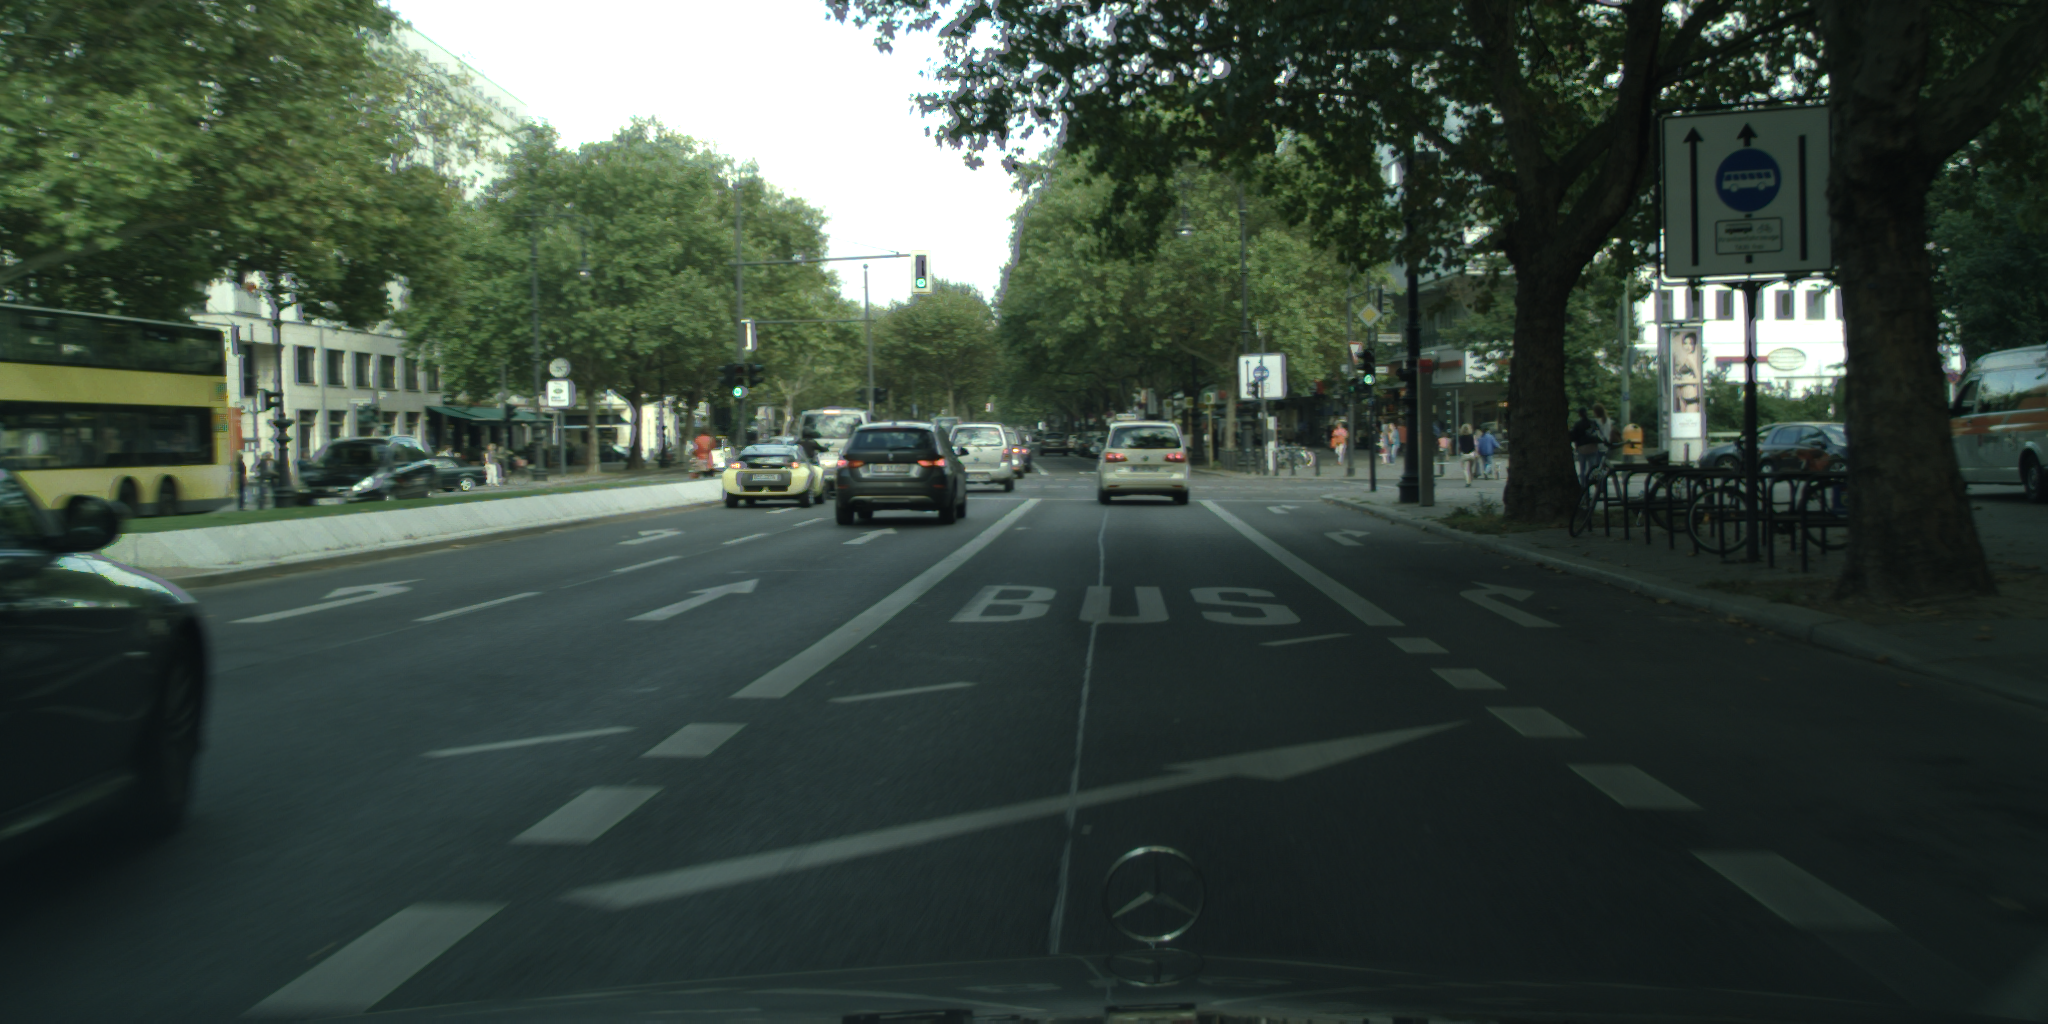

In [ ]:
image

#*Image classification on a new image*

In [ ]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(image).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%") # traffic light: 63.0%

traffic light: 63.0%


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.io import read_image
from PIL import Image
import numpy as np

# Assuming you have already defined ViTSegmentation as before
# Load the pretrained ViT model and your custom segmentation model
# segmentation_model = ViTSegmentation(vit_model=vit_model, num_classes=21)

# Set the model to evaluation mode
# segmentation_model.eval()

# Define a function to preprocess an existing image tensor
def preprocess_image_tensor(image):
    # Define the transformations (resize, normalization) similar to ViTFeatureExtractor
    transform = transforms.Compose([
        transforms.Resize((518, 518)),  # Resize to match ViT input size
        transforms.ConvertImageDtype(torch.float),  # Convert to float32
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
    ])

    image_tensor = transform(image)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 3, 224, 224]

    return image_tensor

# Define a function to postprocess the output
def postprocess_output(output):
    # Apply argmax to get the most likely class for each pixel
    output_predictions = torch.argmax(output, dim=1).squeeze().detach().cpu().numpy()

    return output_predictions

# Read the image
image_tensor = read_image(image_path)  # This reads image as [C, H, W]

# Ensure the image has 3 channels
if image_tensor.shape[0] != 3:
    raise ValueError(f"Expected 3 channels, but got {image_tensor.shape[0]} channels")

# Preprocess the image tensor
input_tensor = preprocess_image_tensor(image_tensor)

In [ ]:
input_tensor.shape

torch.Size([1, 3, 518, 518])

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("CUDA is available. Using GPU.")
else:
  device = torch.device("cpu")
  print("CUDA is not available. Using CPU.")

model = segmentation_model.to(device)
batch = batch.to(device)

In [ ]:
# Perform inference
with torch.no_grad():
    output = segmentation_model(input_tensor)

In [ ]:
# Postprocess the output
segmentation_map = postprocess_output(output)

# Convert to an image for visualization
segmentation_image = Image.fromarray(segmentation_map.astype(np.uint8))

# Save or display the segmentation image
segmentation_image.save('***/Cityscapes/segmentation_map.png')
segmentation_image.show()

# **Recap**

Vision Transformer is deployed to get features, and then it is used to reshape the images to fit into the decoder.

The decoder consists of transposed convolutions (upconvolutions) and regular convolutions, similar to a U-Net style decoder.

Feature Reshaping is applied by reshaping the output from the Vision Transformer to match the dimensions required for the decoder layers. This is a crucial step since the output from ViT is different from CNN-based models.

Ensure that the shape manipulations fit your specific use case, as Vision Transformers and CNNs handle spatial dimensions differently.
You may need to adjust the up-convolution blocks to match the feature sizes and spatial dimensions of your use case.

Feel free to modify the network "as in shared attention modules" or add additional features that are used in unique architectures such as DINOv2, ViT_L, Mask2Former, and Swin Transformer backbones.